<img src='ihe_logo.png' width="250" height="300"></img>

<table style="width: 100%">
<tr>
  <td><center><font size="8">M012-2223T05</font></center></td>
</tr>
<tr>
  <td><center><font size="8">AI for Water Systems - Optimisation</font></center></td>
</tr>
<tr>
   <td><center><font size="5">February 2023</font><center></td>
</tr>
<tr>  
   <td><center><font size="5">Optimisation of Water Distribution Networks with PYMOO and WNTR libraries</font></center></td>
</tr>
<tr>
   <td><center><font size="2">By: Leonardo Alfonso, Associate Professor in Hydroinformatics</font></center></td>
</tr>
       
</table>

# Learning objective
To apply the concepts of single and multiobjective optimisation on a Water Distribution System problem related to contamination events.

# Problem
The flow in the water distribution network in Figure 1 can be controlled by operating the valves `P2`, `P6`, `P10`, `P14` and `P18` and also by opening the hydrants `J17` and `J13`. A pollution event is detected at node `J9`. You have to operate the valves and hydrants to flush the contaminant out the network. What interventions do you propose? How many nodes are affected (i.e., contaminated) by your decision, after a simulation of 48h?

<img src='network.png' width="800" height="800"></img>

# Material
- The EPANET file of the system is given (`prb.inp`).
- A Comma Separated File (`status.csv`) containing the elements that can be changed and their original status. Its content is the following:

<img src='original_element_status.png'></img>

Note that:
- all the pipes (elements whose ID start with the letter `P`) are originally open (Status = 1)
- all the hydrants (elements whose ID start with the letter `J`) are originally closed (Status = 0)

# Tools
For both, we will install the libraries WNTR and PYMOO, described below.

### WNTR
The <a href="https://wntr.readthedocs.io/en/stable/">Water Network Tool for Resilience (WNTR) </a> is a Python package designed by Sandia National Laboratories and the US Environmental Protection Agency, to simulate and analyze resilience of water distribution networks. The software includes capability to, among others:

- Modify network structure and operations
- Add response/repair strategies
- Simulate pressure dependent demand and demand-driven hydraulics
- Simulate water quality

We will use WNTR for:
- automatically changing the status of the given elements in the EPANET model (closing and opening pipes and hydrants)
- run the model(s)
- read the water quality results of the model(s)

### PYMOO
The <a href="https://pymoo.org/index.html">Multi-objective Optimization in Python PYMOO </a> is a Python library that offers a collection of interfaces, algorithms and visualisatoin tools for optimisation.

We will use PYMOO for:
- solving the optimisation problem using as a function that runs EPANET
- display the optimal network configuration found

WNTR and PYMOO are libraries that need to be installed before they can be used. To this end, uncomment the following lines (to be run only one time; after that, these lines can be commented again)

In [1]:
# uncomment the following two lines to install the needed libraries in your laptop; This needs to be done only once:

# %pip install --user pandas
# %pip install --user wntr
# %pip install --user pymoo

In [13]:
# !conda env create -f environment.yml

# Solution
The problem of finding the best operational statuses of the elements `P2`, `P6`, `P10`, `P14`, `P18`, `J17` and `J13` could be solved manually by using trial and error in EPANET, although this is not ideal, as it is tedious and time-consuming. Instead, automatic optimisation procedures can be applied. We will solve the problem in two ways, assuming:
- Single objective optimisation
- Multi objective optimisation

We first load standard libraries as follows:

In [2]:
import sys
import pandas as pd
import wntr
import numpy as np

## Single objective optimisation
For SOO we will find the best operational interventions such that <b>minimise the total number of polluted nodes</b>. 

### Step 1 - create the Objective function as a Python function using WNTR
We need a Python function that receives as input:
- the desired status of the network `new_status`, 
- an object containing the EPANET model as defined in WNTR `epanet_model`, and 
- the original status of the network `elem_status`

And returns as output:
- the number of polluted nodes after 48h of simulation


In [3]:
def num_polluted_nodes(new_status, epanet_model, elem_status):  #Function to calculate Objective Functions
    # Function that change operational status of selected elements

    def set_base_demand(wn, node_id:str, new_base_demand):   
        # Function to set the Base Demand of the node node_id, to the value provided in new_base_demand. wn is the EPANET model object created in WNTR.
        junction = wn.get_node(node_id)
        junction.demand_timeseries_list[0].base_value = new_base_demand
        return
    
    #Loop that makes the changes given in new_status in the EPANET model
    for i, e in enumerate(elem_status['Element']):
        if e[0] == 'J':   #A hydrant
            if new_status[i] == True:
                set_base_demand(epanet_model, e, 6*0.001)            # An open hydrant is assumed to demand a discharge of 6 lps
            else:
                set_base_demand(epanet_model, e, 0.5*0.001)          # A closed hydrant is assumed to demand a 'normal' consumption of 0.5 lps
        if e[0] == 'P':   #A valve
            if new_status[i] == True:
                epanet_model.get_link(e).diameter = 0.162            # All pipes have D=160mm. An open pipe is assumed to keep this diameter.
            else:
                epanet_model.get_link(e).diameter = 0.000001        # A closed pipe is assumed to be one with a very small diameter.

    # Run model
    epanet_model.options.hydraulic.demand_model = 'PDD'
    sim = wntr.sim.EpanetSimulator(epanet_model)
    results = sim.run_sim(version = 2.2)
    
    # Count number of polluted nodes
    q_sim = results.node['quality']
    num_pol_nodes = (q_sim.tail(1)>0.02).sum().sum()                # Number of polluted nodes at the end of the simulation, assuming that a node is polluted if q > 0.02 kg/m3
    
    # uncomment the following line if you want to see the resulting number of polluted nodes in each run:
    #print('Number of polluted nodes ' + str(num_pol_nodes)) 
    
    return num_pol_nodes

### Step 2 - Build the optimisation problem using the PYMOO library

A bounch of libraries must be imported from PYMOO. Note we are using here the <b>GA: Genetic Algorithms</b> optimisation algorithm.

In [4]:
from pymoo.algorithms.soo.nonconvex.ga import GA
#from pymoo.operators.crossover.pntx import TwoPointCrossover
#from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.problems.functional import FunctionalProblem
from pymoo.optimize import minimize

#Create the EPANET model object from the EPANET input file:
epanet_input_file = 'prb.inp'    # Beware: this file needs to exist in the same location as this notebook!
em = wntr.network.WaterNetworkModel(epanet_input_file)

#Read the initial status of the pipes and hydrants in the network, from the given text file
elem_status = pd.read_csv('status.csv') # Beware: this file needs to exist in the same location as this notebook!

# Define objective function
obj = [lambda x: num_polluted_nodes(x, em, elem_status)]     #This line calls the function created in Step 1

#Define constraints
constr_ieq = []
const_l = np.zeros(7)
const_u = np.ones(7)

# Define the problem as requied by PYMOO
problem = FunctionalProblem(7,                    # number of decision variables, the seven elements to change in the model
                            obj,                   # objectives 
                            constr_ieq=constr_ieq,  # constraints
                            xl=const_l,             # lower bound for constraints (0)
                            xu=const_u              # upper bound for constraints (1)
                           )

                            # Setup the algorithm
algorithm = GA(
    pop_size=5,
    sampling=BinaryRandomSampling(),
   # crossover=TwoPointCrossover(),
   # mutation=BitflipMutation(),
    eliminate_duplicates=True)

res = minimize(problem,
               algorithm,
               ('n_gen', 5),
               verbose=True)

print("Best solution found: %s" % res.X.astype(int))
print("Function value: %s" % res.F)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |        5 |  1.860000E+01 |  1.600000E+01
     2 |       10 |  1.580000E+01 |  1.500000E+01
     3 |       15 |  1.540000E+01 |  1.400000E+01
     4 |       20 |  1.440000E+01 |  1.200000E+01
     5 |       25 |  1.200000E+01 |  8.0000000000
Best solution found: [1 0 0 0 0 1 0]
Function value: [8.]


### Step 3 - Interpret the results
You got the optimisation reults as printed above. What do you need to tell the operator what to do in the network?

## Multi-objective optimisation
 
Now suppose that we do not have the resources to phisically perform too many operations in the network (due to limited crew, for example), so we need to minimise these operations as well. This means we now have two objective functions:
 
- minimise the number of polluted nodes
- minimise the number of operational interventions
 
Fortunately, we already have a code to evaluate the first objective. We need now another function to evaluate the second one.
 
### Step 1 - Create a second Python function to evaluate the second Objective function
 
This function simply compares the original status with the new status, and adds one if something is different.
 
For example, if the initial status is
`[1 1 1 1 1 0 0]` 
 
and the new suggested status is:
`[1 1 1 1 0 1 0]` 
 
Then two changes were proposed, namely close `P18` and open `J17`. This is what the following function, `num_operations`, is doing: 

In [5]:
def num_operations(new_status, elem_status):
    
    # Count number of operational changes in the netwrok (Function 2)
    elem_status['Status'] = elem_status['Status'].astype('bool')
    original_status = elem_status['Status'].to_numpy() * 1
    
    op = sum([1 for x, y in zip(original_status, new_status) if x != y])

    # uncomment the following line if you want to see the resulting number of polluted nodes in each run:
    # print('Number of operations: ' + str(op))
    return op
    

### Step 2 - Build the multi-optimisation problem using the PYMOO library

Again, another bounch of libraries must be imported from PYMOO. Now we are using the <b>NSGA2 Non-Sorted Genetic Algorithm</b> optimisation algorithm.
What differences can you spot from the Single Objective Optimisation used above?

In [6]:
from pymoo.optimize import minimize
from pymoo.problems.functional import FunctionalProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.selection.rnd import RandomSelection
from pymoo.operators.crossover.hux import HalfUniformCrossover
from pymoo.operators.sampling.rnd import BinaryRandomSampling

from pymoo.factory import get_crossover, get_mutation, get_sampling
from pymoo.visualization.scatter import Scatter

#Create the EPANET model object from the EPANET input file:
epanet_input_file = 'prb.inp'    # Beware: this file needs to exist in the same location as this notebook!
em = wntr.network.WaterNetworkModel(epanet_input_file)

#Read the initial status of the pipes and hydrants in the network, from the given text file
elem_status = pd.read_csv('status.csv') # Beware: this file needs to exist in the same location as this notebook!

#Definition of objective functions in the way PYMOO library needs them. Note that x is the decision variables (suggested operational changes to do in the network)
objs = [lambda x: num_operations(x, elem_status),           # Evaluate first objective: counting the number of operational changes of the network with respect to original status.
        lambda x: num_polluted_nodes(x, em, elem_status)]   # Evaluate second objective: counting the number of nodes that get polluted with certain operational changes.

#Definition of constraints for the decision variables x
constr_ieq = []
const_l = np.zeros(7)
const_u = np.ones(7)

#Definition of problem for optimisation, as required by the PYMOO library
problem = FunctionalProblem(7,                      # # number of decision variables, the seven elements to change in the model
                            objs,                   # objectives 
                            constr_ieq=constr_ieq,  # constraints
                            xl=const_l,             # lower bound for constraints (0)
                            xu=const_u              # upper bound for constraints (1)
                            )

#Non-Sorted Genetic Algorithm NSGA2 is a very popular multi-objective optimisation algorithm
algorithm = NSGA2(pop_size=10,                         # Number of populations
                 sampling=BinaryRandomSampling())      # our variables are binary (True = open, False = closed)

res = minimize(problem,            # The problem is about minimising both objective functions
               algorithm,          # Using NSGA
               ('n_gen', 5),       # With 10 generations
               verbose=True)       # To see intermediate results, related to the optimisation algorithm. 

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       10 |      2 |             - |             -
     2 |       20 |      2 |  1.0000000000 |         nadir
     3 |       30 |      3 |  0.6666666667 |         ideal
     4 |       40 |      7 |  0.000000E+00 |             f
     5 |       50 |     10 |  0.000000E+00 |             f


If verbose is set to True, the following is displayed:
- n_gen: current generation
- n_eval: number of evaluations (typically n_gen * pop_size)
- n_nds: non-dominated solutions.
- eps and indicator: metrics which represents the movement of solutions in the objective space
See more details at https://pymoo.org/interface/display.html?highlight=verbose. See also https://www.egr.msu.edu/~kdeb/papers/c2020003.pdf for details about 'indicator'

In [7]:
print("Best solution found: \nX = %s\nF = %s" % (res.X.round(), res.F))

Best solution found: 
X = [[1. 0. 1. 1. 1. 1. 0.]
 [1. 1. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 1. 0.]
 [1. 1. 0. 0. 0. 1. 0.]
 [1. 0. 1. 1. 1. 1. 0.]
 [1. 1. 1. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 1. 1. 0.]
 [1. 1. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 1. 1. 0.]]
F = [[ 2. 14.]
 [ 5.  8.]
 [ 4. 12.]
 [ 5.  8.]
 [ 5.  8.]
 [ 5.  8.]
 [ 5.  8.]
 [ 4. 12.]
 [ 5.  8.]
 [ 4. 12.]]


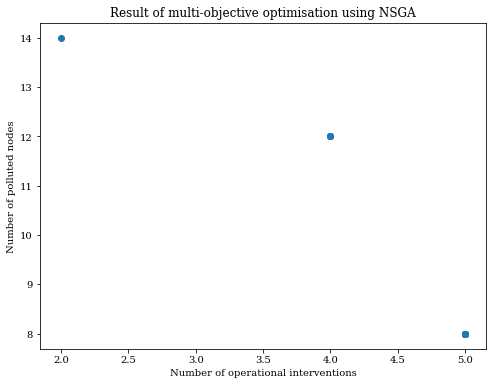

In [8]:
Scatter(title='Result of multi-objective optimisation using NSGA', labels=['Number of operational interventions', 'Number of polluted nodes']).add(res.F).show()


### Step 3 - Interpret the results
You got the optimisation reults as printed above. What do you need to tell the operator what to do in the network?

Question: What about the 'Do nothing' option?

In [9]:
# Write here a code to evaluate the `Do Nothing` option (so F2 = 0 operational interventions):

npd = num_polluted_nodes([1,1,1,1,1,0,0], em, elem_status)

print(npd)

18
